In [54]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,classification_report
!pip install xgboost

In [56]:
#importing the dataset
df_churn=pd.read_csv("Churn_Data.csv")
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [57]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [58]:
df_churn.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [59]:
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [60]:
df_churn.drop(['Surname'],axis=1,inplace=True)
df_churn.drop(['Gender'],axis=1,inplace=True)
df_churn.drop(['RowNumber'],axis=1,inplace=True)
df_churn.drop(['CustomerId'],axis=1,inplace=True)

In [61]:
df_churn.sample(5)

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4139,564,Germany,40,7,108407.34,1,1,1,83681.20,0
843,773,Spain,41,5,0.00,1,1,0,28266.90,1
2777,758,Germany,61,8,125397.21,1,1,0,182184.09,1
8811,610,France,35,7,81905.95,1,1,1,61623.19,0
7081,625,France,36,8,129944.39,2,0,0,198914.80,0


### Setup the palette and create the DataFrame for geographical colors

In [62]:
# Define the color palette
palette = {"Germany": "#F0E100", "France": "#01295F", "Spain": "#F17105"}
palette_df = pd.DataFrame(palette.items(), columns=['Geography', 'Color'])

# Display the palette DataFrame
palette_df

,Geography,Color
0,Germany,#F0E100
1,France,#01295F
2,Spain,#F17105


### customers DataFrame with geographical counts

In [63]:

customersa = pd.DataFrame(df_churn['Geography'].value_counts(normalize=False)).reset_index()
customersa = customersa.rename(columns={'index': 'Geography', 'Geography': 'Count'})

# Merge with the palette DataFrame
customers = pd.merge(customersa, palette_df, on='Geography', how='outer')

# Display the merged customers DataFrame
customers

,Geography,Count,Color
0,France,5014,#01295F
1,Germany,2509,#F0E100
2,Spain,2477,#F17105


### pie chart for geographical distribution of all customers

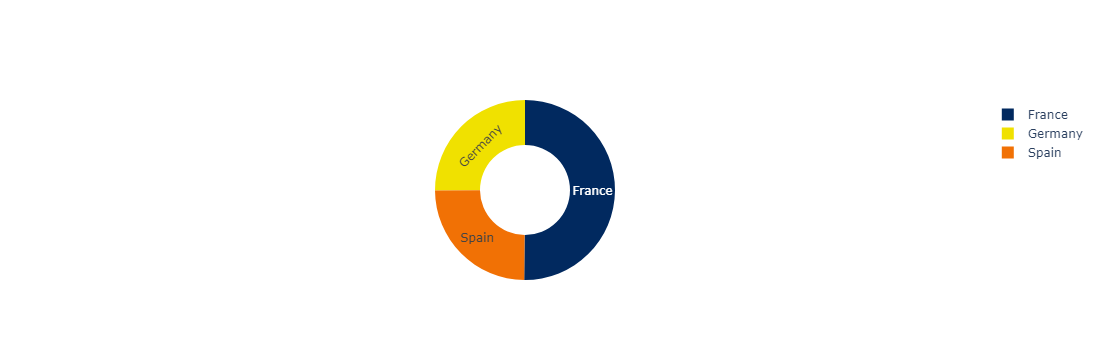

In [64]:
fig = go.Figure(data=[go.Pie(labels=customers['Geography'], values=customers['Count'], textinfo='label',
                             name='Customers Geographical Locations', 
                             marker_colors=customers['Color'], hole=0.5)])

# Show the pie chart
fig.show()

###  data for churners and non-churners based on geography

In [65]:
# Separate churners and non-churners
churners = df_churn[df_churn['Exited'] == 1]
nonchurners = df_churn[df_churn['Exited'] == 0]

# Count churners by geography
churners_counta = pd.DataFrame(churners['Geography'].value_counts(normalize=False)).reset_index()
churners_counta = churners_counta.rename(columns={'index': 'Geography', 'Geography': 'Count'})
churners_count = pd.merge(churners_counta, palette_df, on='Geography', how='outer')

# Count non-churners by geography
nonchurners_counta = pd.DataFrame(nonchurners['Geography'].value_counts(normalize=False)).reset_index()
nonchurners_counta = nonchurners_counta.rename(columns={'index': 'Geography', 'Geography': 'Count'})
nonchurners_count = pd.merge(nonchurners_counta, palette_df, on='Geography', how='outer')

# Display the churners and non-churners DataFrames
churners_count, nonchurners_count

(  Geography  Count    Color
 0   Germany    814  #F0E100
 1    France    810  #01295F
 2     Spain    413  #F17105,
   Geography  Count    Color
 0    France   4204  #01295F
 1     Spain   2064  #F17105
 2   Germany   1695  #F0E100)

### churners and non-churners pie charts

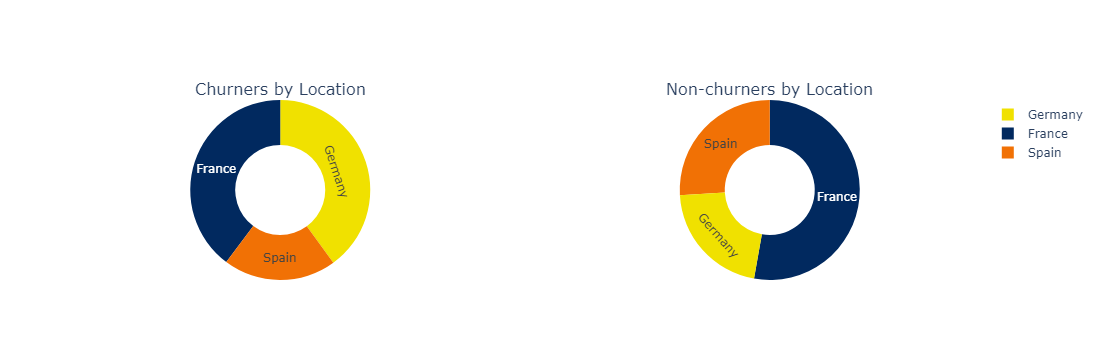

In [66]:
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=("Churners by Location", "Non-churners by Location"))

# Churners pie chart
fig.add_trace(go.Pie(labels=churners_count['Geography'], values=churners_count['Count'], textinfo='label',
                     name='Churners Geographical Locations', 
                     marker_colors=churners_count['Color'], hole=0.5), 1, 1)

# Non-churners pie chart
fig.add_trace(go.Pie(labels=nonchurners_count['Geography'], values=nonchurners_count['Count'], textinfo='label',
                     name='Non-Churners Geographical Locations',  
                     marker_colors=nonchurners_count['Color'], hole=0.5), 1, 2)

# Show the plot
fig.show()

### Churners and Non - Churners distribution of age by geography

Text(0.5, 1.0, 'Age Distribution of Non-Churners by Geography')

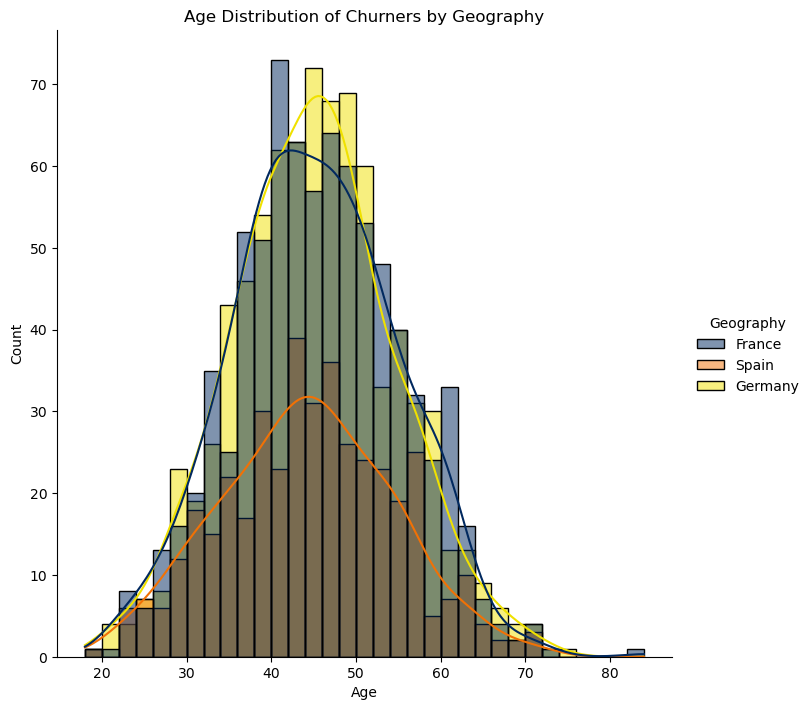

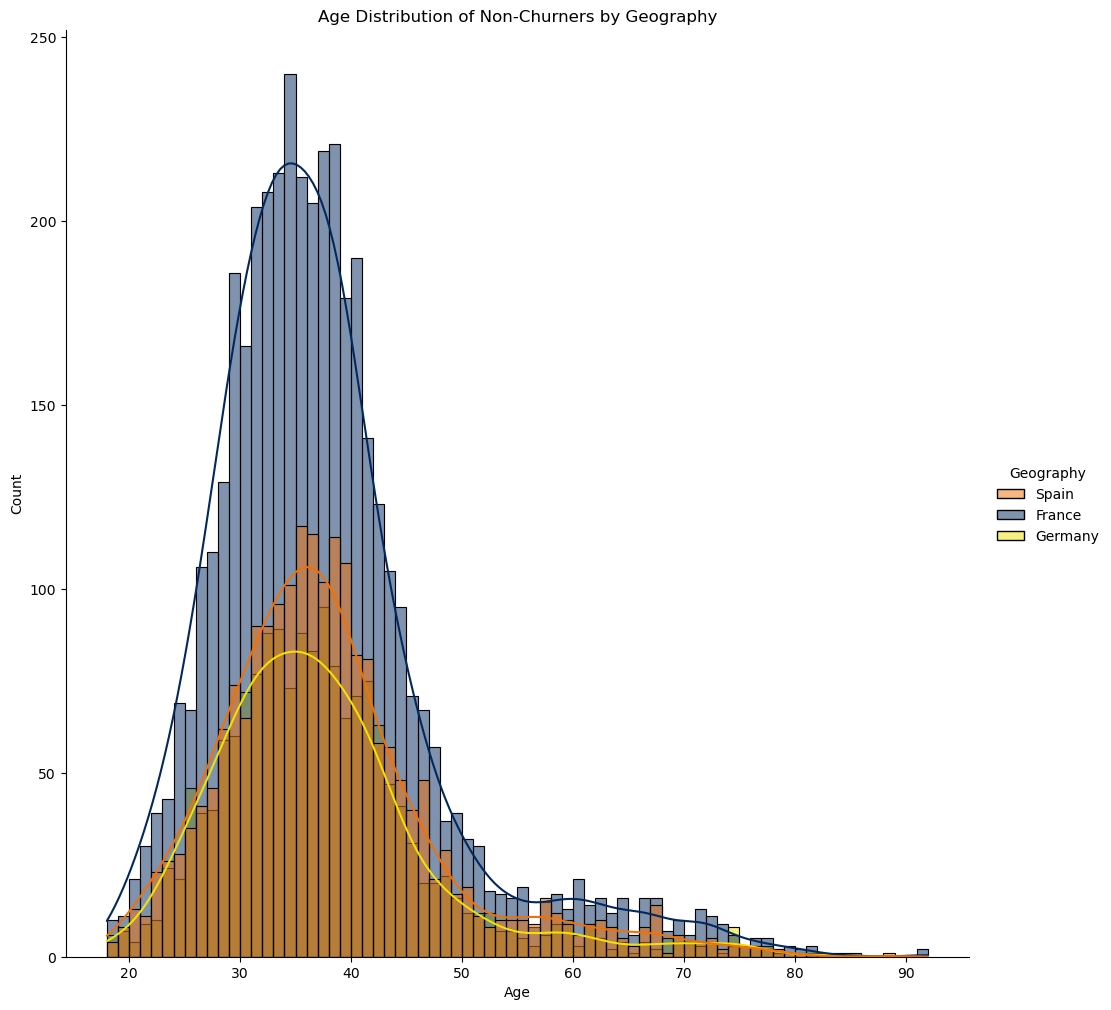

In [67]:
# Plot Age distribution for churners by Geography
sns.displot(data=churners, x="Age", hue='Geography', kde=True, height=7, palette=palette)
plt.title("Age Distribution of Churners by Geography")
# Plot Age distribution for non-churners by Geography
sns.displot(data=nonchurners, x="Age", hue='Geography', kde=True, height=10, palette=palette)
plt.title("Age Distribution of Non-Churners by Geography")

Text(0.5, 1.0, 'Estimated Salary Distribution by Churn Status')

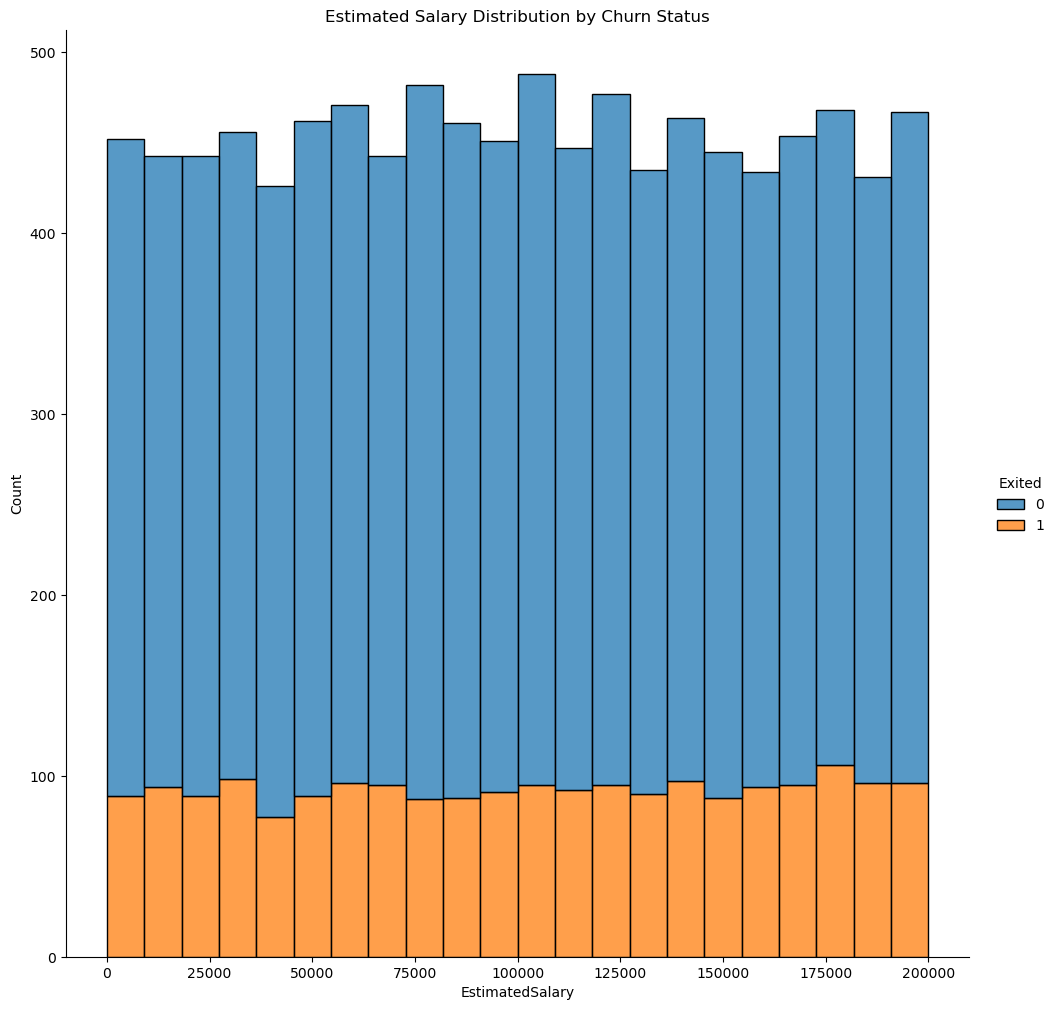

In [68]:
# Plot Estimated Salary distribution by churn status
sns.displot(df_churn, x="EstimatedSalary", hue="Exited", multiple="stack", height=10)
plt.title("Estimated Salary Distribution by Churn Status")

Text(0.5, 1.0, 'Credit Score Distribution of Churners by Geography')

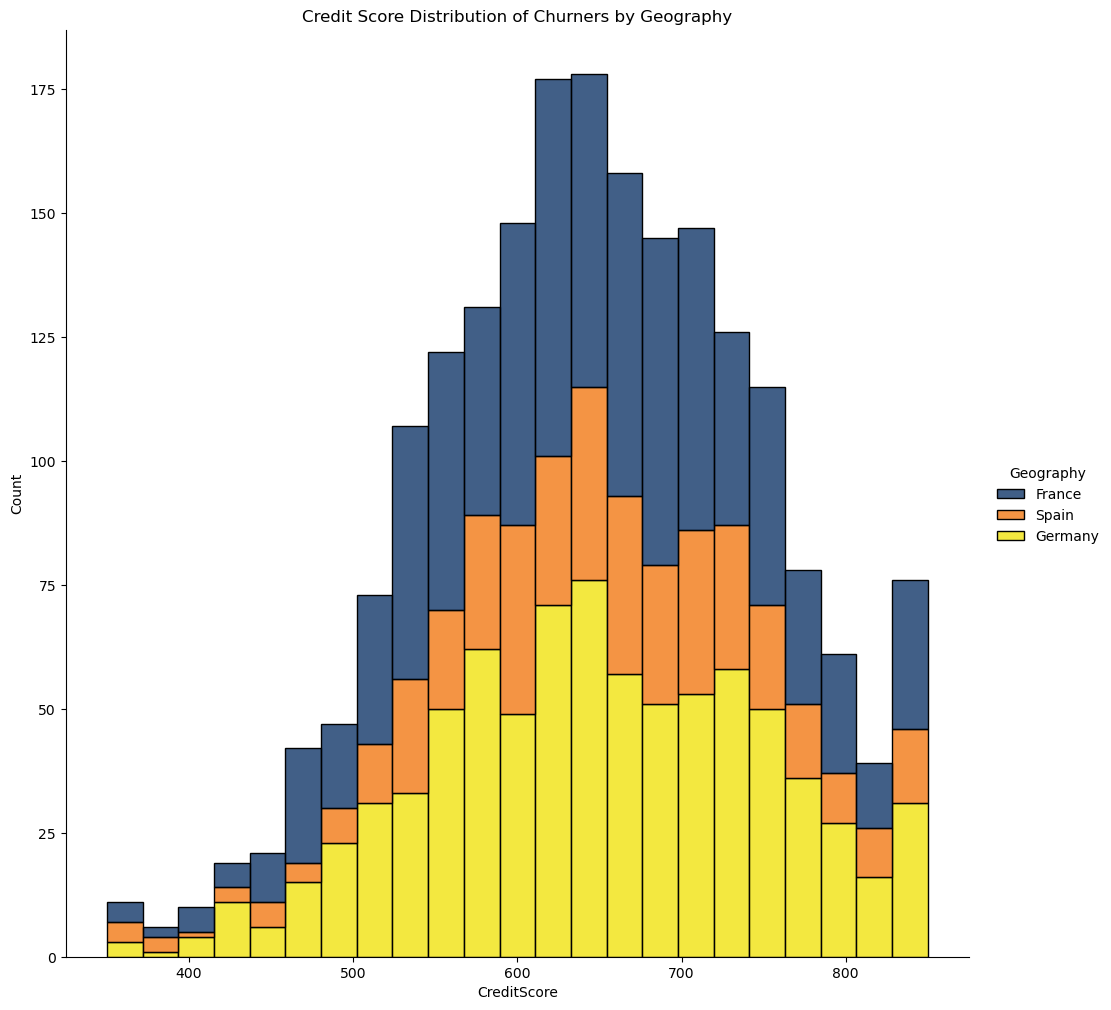

In [69]:
# Plot Credit Score distribution for churners by Geography
sns.displot(churners, x="CreditScore", hue="Geography", multiple="stack", height=10, palette=palette)
plt.title("Credit Score Distribution of Churners by Geography")

### churn balance distribution

Text(0, 0.5, 'Count')

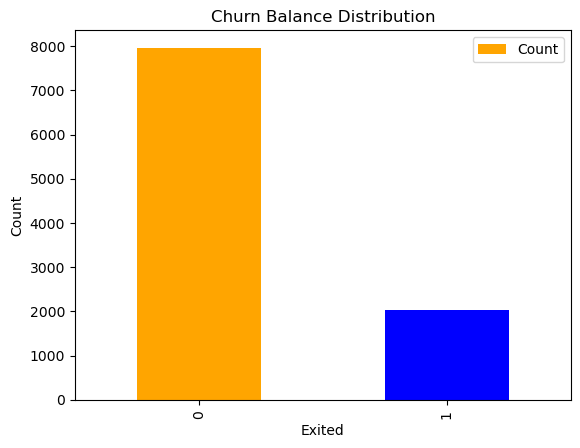

In [70]:
# Create a DataFrame for churn balance
balance_df = pd.DataFrame(df_churn['Exited'].value_counts(normalize=False)).reset_index()
balance_df = balance_df.rename(columns={'index': 'Exited', 'Exited': 'Count'})

# Display the balance DataFrame
balance_df

# Optionally, you can plot the balance distribution
balance_df.plot(kind='bar', x='Exited', y='Count', title='Churn Balance Distribution', 
                color=['orange' if exited == 0 else 'blue' for exited in balance_df['Exited']])

plt.xlabel('Exited')
plt.ylabel('Count')

### Geography unique values and label encoding

In [71]:
from sklearn.preprocessing import LabelEncoder

# Display unique values in Geography column
df_churn['Geography'].unique()

# Label encoding for Geography column
le = LabelEncoder()
df_churn['Geography'] = le.fit_transform(df_churn['Geography'])

# Display the encoding mapping
le_geography_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [72]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Scaling the data
sc = StandardScaler()
X_rftrain = sc.fit_transform(X_train)
X_rftest = sc.transform(X_test)

# Initializing the RandomForestClassifier
rfc = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=10, max_features='sqrt')  # 'auto' is deprecated, use 'sqrt' for classification

# Training the model
rfc.fit(X_rftrain, y_train)

# Evaluating on the training set
rfc_pred_train = rfc.predict(X_rftrain)

# Evaluating on the test set
rfc_pred_test = rfc.predict(X_rftest)

# Displaying confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc_pred_test))

# Display accuracy score
accuracy_rf = accuracy_score(y_test, rfc_pred_test) * 100
print("The accuracy score of the Random Forest Classification Model is: {:.2f}%".format(accuracy_rf))

# Display classification report
print("Classification Report:")
print(classification_report(y_test, rfc_pred_test))


Confusion Matrix:
[[1911   69]
 [ 276  244]]
The accuracy score of the Random Forest Classification Model is: 86.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1980
           1       0.78      0.47      0.59       520

    accuracy                           0.86      2500
   macro avg       0.83      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



In [73]:
X = df_churn.drop("Exited", axis=1)
y = df_churn['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
#XGBoost
xgb_churn = xgb.XGBClassifier(gamma= 1.0,learning_rate= 0.15,max_depth= 7,
                              n_estimators= 100)
xgb_churn.fit(X_train, y_train)
predictions = xgb_churn.predict(X_test)
accuracy_xgb = accuracy_score(y_test, predictions) * 100
print("The accuracy score of the XGBoost Classification Model is: ",accuracy_xgb)

The accuracy score of the XGBoost Classification Model is:  87.08


In [74]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Scaling the data (same as in your original code)
sc = StandardScaler()
X_dtt_train = sc.fit_transform(X_train)
X_dtt_test = sc.transform(X_test)

# Initializing the DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini', random_state=10, max_features='sqrt')

# Training the model
dtc.fit(X_dtt_train, y_train)

# Evaluating on the training set
dtc_pred_train = dtc.predict(X_dtt_train)

# Evaluating on the test set
dtc_pred_test = dtc.predict(X_dtt_test)

# Displaying confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, dtc_pred_test))

# Display accuracy score
accuracy_dt = accuracy_score(y_test, dtc_pred_test) * 100
print("The accuracy score of the Decision Tree Classification Model is: {:.2f}%".format(accuracy_dt))

# Display classification report
print("Classification Report:")
print(classification_report(y_test, dtc_pred_test))


Confusion Matrix:
[[1730  250]
 [ 244  276]]
The accuracy score of the Decision Tree Classification Model is: 80.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1980
           1       0.52      0.53      0.53       520

    accuracy                           0.80      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.80      0.80      0.80      2500



In [75]:
# Importing XGBoost classifier
from xgboost import XGBClassifier

# Scaling the data (same as in your original code)
sc = StandardScaler()
X_dtt_train = sc.fit_transform(X_train)
X_dtt_test = sc.transform(X_test)

# Initializing the XGBoostClassifier
xgb_clf = XGBClassifier(criterion='gini', random_state=10, max_features='sqrt', use_label_encoder=False)

# Training the model
xgb_clf.fit(X_dtt_train, y_train)

# Evaluating on the training set
xgb_pred_train = xgb_clf.predict(X_dtt_train)

# Evaluating on the test set
xgb_pred_test = xgb_clf.predict(X_dtt_test)

# Displaying confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred_test))

# Display accuracy score
accuracy_xgb = accuracy_score(y_test, xgb_pred_test) * 100
print("The accuracy score of the XGBoost Classification Model is: {:.2f}%".format(accuracy_xgb))

# Display classification report
print("Classification Report:")
print(classification_report(y_test, xgb_pred_test))


Confusion Matrix:
[[1893   87]
 [ 254  266]]
The accuracy score of the XGBoost Classification Model is: 86.36%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1980
           1       0.75      0.51      0.61       520

    accuracy                           0.86      2500
   macro avg       0.82      0.73      0.76      2500
weighted avg       0.86      0.86      0.85      2500



C:\Users\Sagar\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[20:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features", "use_label_encoder" } are not used.


